__NOTE:__ For transforming the bboxes by albumentations library make sure you convert the bbox into 'coco' format which is [x_min, y_min, width, height], since it is the most stable. On repeated experimentation it was found that 'yolo' and 'pascal_voc' seems to be broken.

# Importing Library

In [1]:
import torch
from torch import nn
from torch import optim
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
import selectivesearch
import os
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Hyperparameters

In [2]:
img_aug_p = 0.5

# Helper Functions

In [3]:
# Ref: https://albumentations.ai/docs/examples/example_bboxes/
def draw_bounding_boxes(image, bbox, category):
    x_1, y_1, width, height = bbox
    x_1, y_1, x_2, y_2 = int(x_1), int(y_1), int(x_1 + width), int(y_1 + height)
    cv2.rectangle(image, (x_1, y_1), (x_2, y_2), (255, 0, 0), thickness=2, lineType = cv2.LINE_AA)
    ((text_width, text_height), _) = cv2.getTextSize(category, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)    
    cv2.rectangle(image, (x_1, y_1 - int(1.3 * text_height)), (x_1 + text_width, y_1), (0, 0, 0), -1)
    cv2.putText(image, category, (x_1, y_1 - int(0.3 * text_height)), cv2.FONT_HERSHEY_SIMPLEX, 0.35, (255, 255, 255))
    return image

def visualize_bbox(image, bboxes, category_idxs, idx_to_cat):
    img = image.copy()
    for bbox, category_idx in zip(bboxes, category_idxs):
        category = idx_to_cat[category_idx]
        img = draw_bounding_boxes(img, bbox, category)
    plt.figure(figsize = (8,8))
    plt.imshow(img)
    plt.axis('off')

# Loading Data and Visualization

In [4]:
base_folder = pathlib.Path('data/coco')
train_image_folder = base_folder/'train2017'
valid_image_folder = base_folder/'val2017'
train_csv = pd.read_csv(base_folder/'train.csv')
valid_csv = pd.read_csv(base_folder/'valid.csv')
train_csv['path'] = list(map(lambda x:train_image_folder/x, train_csv['file_name']))
# Transforming width and height column to width and height of the bounding box
train_csv['width'] = train_csv['x_2'].values - train_csv['x_1'].values
train_csv['height'] = train_csv['y_2'].values - train_csv['y_1'].values

# Valid
valid_csv['path'] = list(map(lambda x:valid_image_folder/x, valid_csv['file_name']))
# Transforming width and height column to width and height of the bounding box
valid_csv['width'] = valid_csv['x_2'].values - valid_csv['x_1'].values
valid_csv['height'] = valid_csv['y_2'].values - valid_csv['y_1'].values
train_csv.head()

,image_id,file_name,width,height,x_1,y_1,x_2,y_2,category_idx,category_name,path
0,9,000000000009.jpg,75,46,376,40,451,86,55,orange,data/coco/train2017/000000000009.jpg
1,9,000000000009.jpg,58,47,465,38,523,85,55,orange,data/coco/train2017/000000000009.jpg
2,9,000000000009.jpg,320,228,311,4,631,232,51,bowl,data/coco/train2017/000000000009.jpg
3,9,000000000009.jpg,316,245,249,229,565,474,56,broccoli,data/coco/train2017/000000000009.jpg
4,9,000000000009.jpg,94,71,364,2,458,73,55,orange,data/coco/train2017/000000000009.jpg


In [5]:
idx_to_cat = set(train_csv.groupby(['category_idx', 'category_name']).groups)
idx_to_cat = dict(idx_to_cat)
cat_to_idx = {v:k for k,v in idx_to_cat.items()}

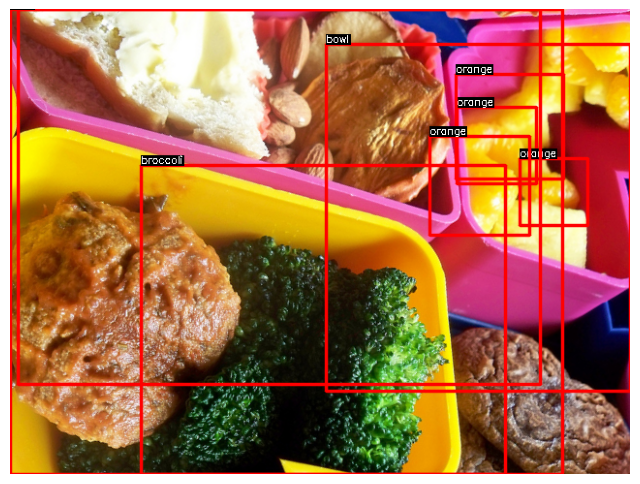

In [6]:
# Checking Transformation
transforms = A.Compose([A.HorizontalFlip(p = img_aug_p),
                        A.ShiftScaleRotate(p = img_aug_p)],
                       bbox_params=A.BboxParams('coco', label_fields=['category_idx']))
idx = 0
file_name = train_csv['file_name'].iloc[idx]
df_sub = train_csv[train_csv['file_name'] == file_name].copy()
file_path = train_image_folder/file_name
img = cv2.imread(str(file_path), cv2.IMREAD_UNCHANGED)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
bboxes = df_sub[['x_1', 'y_1', 'width', 'height']].values.tolist()
category_idx = df_sub['category_idx'].values.tolist()
transformed = transforms(image = img, bboxes = bboxes, category_idx=category_idx)
visualize_bbox(transformed['image'], transformed['bboxes'], transformed['category_idx'], idx_to_cat)